In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random

from argparse import ArgumentParser
import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn


from pytvision.datasets.factory  import FactoryDataset 
from pytvision.datasets.datasets import Dataset 
from pytvision.datasets.fersynthetic  import SyntheticFaceDataset
from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
# from torchlib.datasets.factory  import FactoryDataset 
# from torchlib.datasets.datasets import Dataset 
# from torchlib.datasets.fersynthetic  import SyntheticFaceDataset
from torchlib.neuralnet import NeuralNetClassifier
from misc import get_transforms_det

from sklearn import metrics

In [2]:
pathname = os.path.expanduser( '~/.datasets' )
projectnet='../out/baselinenetruns/'
no_cuda=False
seed=1
gpu=0
batch_size=60
workers=10
num_input_channels=3

print(pathname)
print(projectnet)


/home/fernandez/.datasets
../out/baselinenetruns/


In [3]:
# !ls ../out/baselinenetruns/
!ls ../out/baselinenetruns/

baseline_ferattention_cross_adam_ferp_weights_000
baseline_ferattention_cross_adam_ferp_weights_norm_000
baseline_ferattentionstn_cross_adam_ferp_cvgg13_weights_norm_000
baseline_ferattentionstn_cross_adam_ferp_preactresnet18_weights_norm_000
baseline_ferattentionstn_cross_adam_ferp_weights_norm_000
baseline_ferattentionstn_cross_sgd_ferp_preactresnet18_weights_norm_000


In [6]:
# baseline_cvgg13_cross_adam_affectnet_weights_000
# baseline_preactresnet18_cross_adam_affectnet_weights_000
# baseline_resnet18_cross_adam_affectnet_weights_000
# baseline_fmp_cross_adam_affectnet_weights_000

In [8]:
name = 'baseline_ferattentionstn_cross_adam_ferp_cvgg13_weights_norm_000'
project = os.path.join(projectnet, name)
model = 'chk000149.pth.tar' #'chk000025.pth.tar', model_best
pathmodels = os.path.join(project,'models',model)

print(project)
print(pathmodels)

../out/baselinenetruns/baseline_ferattentionstn_cross_adam_ferp_cvgg13_weights_norm_000
../out/baselinenetruns/baseline_ferattentionstn_cross_adam_ferp_cvgg13_weights_norm_000/models/chk000149.pth.tar


## Load model

In [9]:
# neuralnet
network = NeuralNetClassifier(
    patchproject=project,
    nameproject=name,
    no_cuda=no_cuda,
    seed=seed,
    gpu=gpu
    )

cudnn.benchmark = True

# load model
if network.load( pathmodels ) is not True:
    assert(False)

=> loading checkpoint '../out/baselinenetruns/baseline_ferattentionstn_cross_adam_ferp_cvgg13_weights_norm_000/models/chk000149.pth.tar'
=> loaded checkpoint for ferattentionstn arch!


In [10]:
name_dataset=FactoryDataset.ferp
subset=FactoryDataset.test

nactores=10
kfold=0
idenselect = np.arange(nactores) + kfold*nactores
breal=True

if breal:
    data = Dataset(
        data=FactoryDataset.factory(
            pathname=pathname, 
            name=name_dataset, 
            subset=subset, 
            #idenselect=idenselect,
            download=True ),
        num_channels=num_input_channels,
        transform=get_transforms_det(network.size_input) #network.size_input
        )
else:
    data = SyntheticFaceDataset(
        data=FactoryDataset.factory(
            pathname=pathname, 
            name=name_dataset, 
            subset=subset, 
            idenselect=idenselect,
            download=True 
            ),
        pathnameback='~/.datasets/coco', 
        generate='image_and_label',
        ext='jpg',
        count=2000,
        num_channels=network.num_input_channels,
        iluminate=True, angle=45, translation=0.3, warp=0.2, factor=0.2,
        #iluminate=True, angle=45, translation=0.1, warp=0.0, factor=0.0,
        transform_image=get_transforms_det( network.size_input )
        )


dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=workers )

print('Data loader ')
print(len(dataloader))
print(len(data))

Data loader 
53
3137


In [11]:
import cv2
def imageshow( image ):
    plt.figure( figsize=(10,10))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.ioff()
    plt.show()
    
def roi( image, box ):
    imgray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    roi_gray = imgray[box[1]:box[3], box[0]:box[2]]
    return roi_gray

def vistensor(tensor, ch=0, allfeature=False, nrow=8, padding=1, brgb=True, scol=1, srow=1): 
    """
    vistensor: visuzlization tensor
        @ch: visualization channel 
        @allkernels: visualization all tensores
    """        
    n,c,w,h = tensor.shape
    if allfeature: tensor = tensor.view(n*c,-1,w,h )
    elif brgb:
        tensor = tensor[:,ch:(ch+3),:,:]
    else: 
        tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    
    #print(grid.shape)
    #print(nrow,rows)
    
    plt.figure( figsize=(nrow*scol,rows*srow) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.ioff()
    plt.show()
    
def mean_normalization(image, mean, std):
    tensor = image.float()/255.0
    result_tensor = []
    for t, m, s in zip(tensor, mean, std):  
        result_tensor.append(t.sub_(m).div_(s))            
    return torch.stack(result_tensor, 0)
    

torch.Size([64, 64, 3]) tensor(0.) tensor(0.9451)


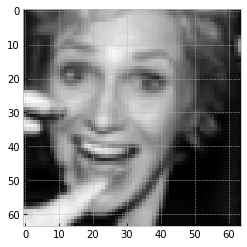

In [61]:
import matplotlib.pyplot as plt 
img = np.transpose( data[6]['image'], (1,2,0) )
print( img.shape, img.min(), img.max() )
plt.figure()
plt.imshow( img[:,:,0], cmap='gray' )
plt.show()

# cv2.imwrite( '../out/real.png', img[:,:,0].numpy()*255  )


torch.Size([1, 8, 64, 64])


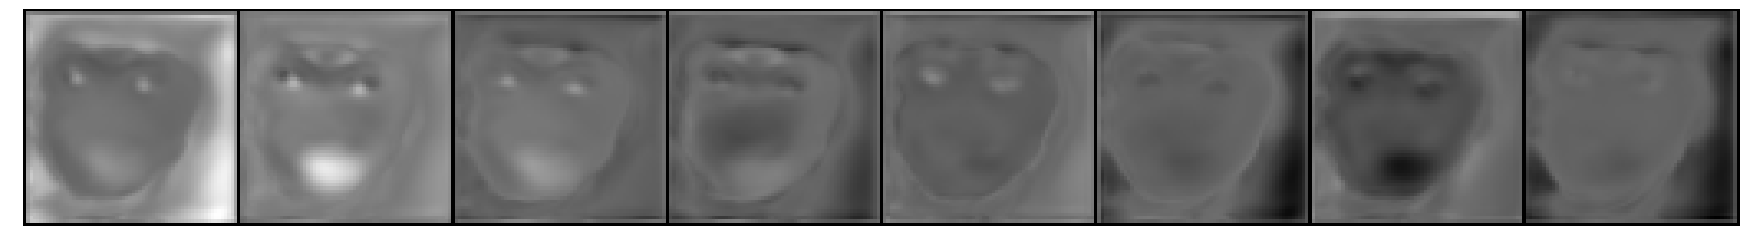

In [62]:
nt = network.net

x = img
x = x.cuda()
x = x.permute( (2,0,1) ).unsqueeze(0).float().cuda()
# x = x/255.0

nt.eval()
lg_att = nt.attention_map( x )

print(lg_att.shape)
vistensor( lg_att.cpu().detach(), nrow=8 , allfeature=True, brgb=False, scol=25, srow=2 )


torch.Size([1, 8, 64, 64])


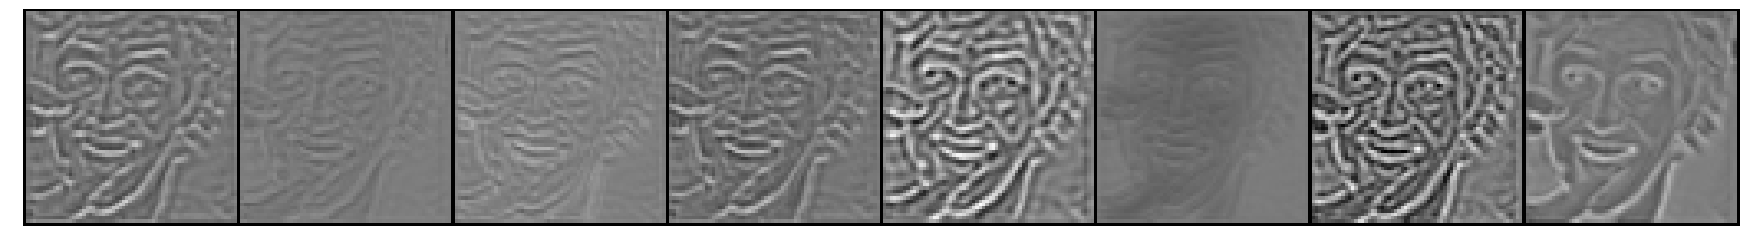

In [63]:
#feature module

out = nt.conv_input( x )
residual = out
out = nt.feature( out )
out = nt.conv_mid(out)
lg_ft = torch.add(out, residual )

print(lg_ft.shape)
vistensor( lg_ft.cpu().detach(), nrow=8 , allfeature=True, brgb=False, scol=25, srow=2 )

torch.mul( TF.sigmoid( lg_att ) ,  lg_ft ) 
torch.Size([1, 8, 64, 64])


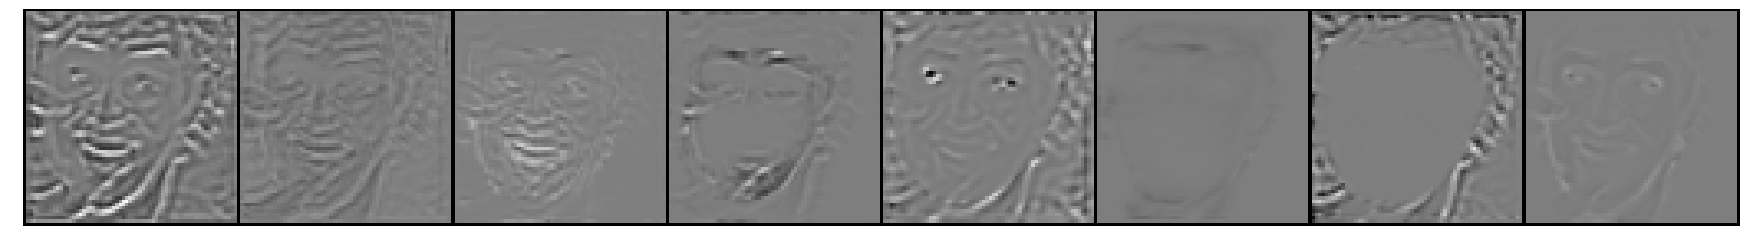

nt.reconstruction( torch.cat( (lattmap, x, lg_att) , dim=1 ) ) 
torch.Size([1, 3, 64, 64])


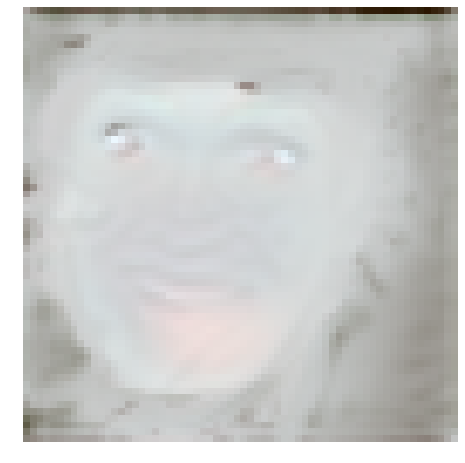

TF.relu(nt.conv2_bn(latt)) 
torch.Size([1, 3, 64, 64])


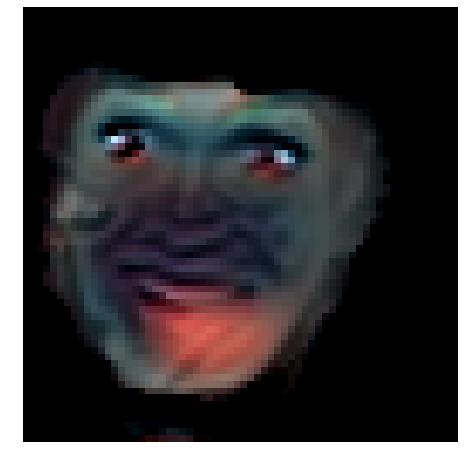

In [65]:
from torch.nn import functional as TF

def normalize_layer(x):
    x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
    x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
    x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
    x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
    return x


lattmap = torch.mul( TF.sigmoid( lg_att ),  lg_ft )   
latt = nt.reconstruction( torch.cat( (lattmap, x, lg_att) , dim=1 ) )   
latt_norm = TF.relu(nt.conv2_bn(latt))


print('torch.mul( TF.sigmoid( lg_att ) ,  lg_ft ) ')
print(lattmap.shape)
vistensor( lattmap.cpu().detach(), nrow=8 , allfeature=True, brgb=False, scol=25, srow=2 )

print('nt.reconstruction( torch.cat( (lattmap, x, lg_att) , dim=1 ) ) ')
print(latt.shape)
vistensor( latt.cpu().detach(), nrow=3 , allfeature=False, brgb=True, scol=8, srow=8 )

print('TF.relu(nt.conv2_bn(latt)) ')
print(latt_norm.shape)
vistensor( latt_norm.cpu().detach(), nrow=3 , allfeature=False, brgb=True, scol=8, srow=8 )



F.grid_sample(latt_norm, grid)
torch.Size([1, 3, 64, 64])


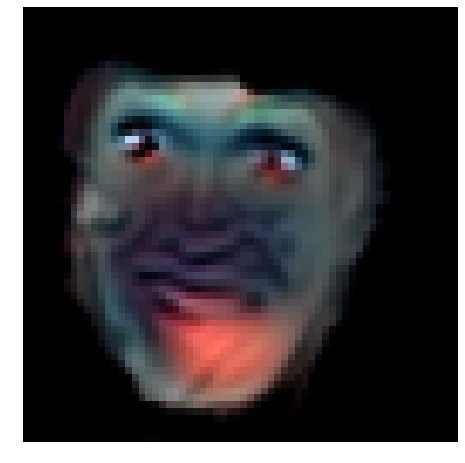

In [66]:
#stn
theta = nt.stn( latt_norm.mean(dim=1).unsqueeze(dim=1).detach() ) 
grid = TF.affine_grid(theta, latt_norm.size())
latt_stn = TF.grid_sample(latt_norm, grid) 
latt_t = normalize_layer(latt_stn)

# latt_pool = TF.interpolate(latt_t, size=(224,224) ,mode='bilinear', align_corners=False) #if resnet
# latt_pool = TF.avg_pool2d(latt_t, 2)  
latt_pool = latt_t

print('F.grid_sample(latt_norm, grid)')
print(latt_pool.shape)
vistensor( latt_stn.cpu().detach(), nrow=3 , allfeature=False, brgb=True, scol=8, srow=8 )


# im =  latt_stn[0,:,:,:].permute( 1,2,0 ).detach().cpu().numpy()*255;
# cv2.imwrite( '../out/stn.png',  im[:,:,(2,1,0)] )


In [68]:
ntc = nt.netclass

# out1 = ntc.conv1(latt_pool)
# out2 = ntc.bn1(out1)
# out3 = ntc.relu(out2)
# out4 = ntc.maxpool(out3)
# out5 = ntc.layer1(out4)

# out1 = ntc.conv1(latt_pool)
# out2 = ntc.layer1(out1)
# out3 = ntc.layer2(out2)
# out4 = ntc.layer3(out3)
# out5 = ntc.layer4(out4)

# print('ntc.conv1(latt_pool)')
# print(out1.shape)
# vistensor( out1.cpu().detach(), nrow=16 , allfeature=True, brgb=False, scol=3, srow=1.5 )

# print('ntc.relu(out2)')
# print(out2.shape)
# vistensor( out2.cpu().detach(), nrow=16 , allfeature=True, brgb=False, scol=3, srow=1.5 )

# print('ntc.layer1(out3)')
# print(out3.shape)
# vistensor( out3.cpu().detach(), nrow=16 , allfeature=True, brgb=False, scol=3, srow=1.5 )


In [67]:
# out6 = ntc.layer2(out5)
# out7 = ntc.layer3(out6)
# out8 = ntc.layer4(out7)

# print('ntc.layer1(out6)')
# print(out6.shape)
# vistensor( out6.cpu().detach(), nrow=16 , allfeature=True, brgb=False, scol=3, srow=1.5 )

# print('ntc.layer1(out7)')
# print(out7.shape)
# vistensor( out7.cpu().detach(), nrow=16 , allfeature=True, brgb=False, scol=3, srow=1.5 )

# print('ntc.layer1(out8)')
# print(out8.shape)
# vistensor( out8.cpu().detach(), nrow=16 , allfeature=True, brgb=False, scol=3, srow=1.5 )



In [26]:
Yhat, Y = network.test( dataloader )
df = pd.DataFrame( np.concatenate((Yhat, Y), axis=1) )
df.to_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset,name,name_dataset)), index=False, encoding='utf-8')       

print('dir: {}'.format(project))
print('DONE!!!')

100%|██████████| 53/53 [00:05<00:00,  8.89it/s]

dir: ../out/baselinenetruns/baseline_ferattentionstn_cross_adam_ferp_cvgg13_weights_norm_000
DONE!!!


In [27]:
df = pd.read_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset, name, name_dataset))  )
df.head()

,0,1,2,3,4,5,6,7,8
0,8.292907e-02,0.001696,3.002224e-06,8.928031e-01,2.157413e-02,1.568310e-04,8.366513e-04,1.138868e-06,7.0
1,9.996603e-01,0.000003,3.257432e-04,1.478682e-06,8.975661e-06,1.665190e-07,2.246752e-08,9.622074e-07,0.0
2,5.299598e-04,0.000021,9.971790e-06,8.212350e-07,9.994360e-01,1.521364e-06,8.877808e-10,8.049286e-07,4.0
3,9.998800e-01,0.000002,8.729756e-06,1.017711e-04,1.977754e-06,2.445053e-06,2.987107e-07,2.394781e-06,0.0
4,5.222733e-07,0.999997,2.234732e-08,2.354714e-06,1.771325e-07,5.538268e-08,3.720576e-10,1.212186e-07,1.0


In [28]:
result = df.as_matrix()
yhat = np.argmax( result[:,:-1], axis=1 )
y = result[:,-1]

acc = metrics.accuracy_score(y, yhat)
precision = metrics.precision_score(y, yhat, average='weighted')
recall = metrics.recall_score(y, yhat, average='weighted')

# precision = metrics.precision_score(y, yhat, average='macro' )
# recall = metrics.recall_score(y, yhat, average='macro' )
f1_score = 2*precision*recall/(precision+recall)

# print('Accuracy : %f' % acc)
# print('Precision : %f' % precision)
# print('Recall : %f' % recall)
# print('F1 score : %f' % f1_score)
# print("")
print('|Acc\t|Prec\t|Rec\t|F1\t|')
print( '|{:0.3f}\t|{:0.3f}\t|{:0.3f}\t|{:0.3f}\t|'.format(acc,precision,recall,f1_score).replace('.',',')  )

print()
print( '{:0.3f}\n{:0.3f}\n{:0.3f}\n{:0.3f}'.format(acc*100,precision*100,recall*100,f1_score*100).replace('.',',')  )

|Acc	|Prec	|Rec	|F1	|
|0,845	|0,843	|0,845	|0,844	|

84,476
84,310
84,476
84,393


In [29]:
metric = metrics.classification_report(y, yhat)
print(metric)


              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85      1083
         1.0       0.92      0.94      0.93       892
         2.0       0.86      0.87      0.86       394
         3.0       0.70      0.67      0.68       382
         4.0       0.86      0.79      0.82       269
         5.0       0.67      0.50      0.57        16
         6.0       0.74      0.49      0.59        86
         7.0       1.00      0.20      0.33        15

   micro avg       0.84      0.84      0.84      3137
   macro avg       0.82      0.67      0.71      3137
weighted avg       0.84      0.84      0.84      3137



In [31]:
mc = metrics.confusion_matrix(y, yhat)
# print(mc)
print( np.diag( mc ) )


[945 841 343 256 212   8  42   3]


Normalized confusion matrix
[87.25761773 94.28251121 87.05583756 67.01570681 78.81040892 50.
 48.8372093  20.        ]


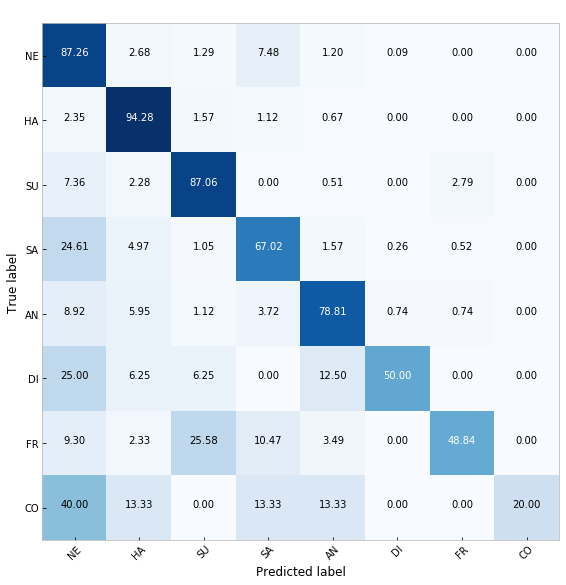

In [32]:
import itertools
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm*100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    print( np.diag(cm) )

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


matplotlib.style.use('bmh')
plt.figure( figsize=(8,8))
emotion = np.array(['NE', 'HA', 'SU', 'SA', 'AN', 'DI', 'FR', 'CO'])
plot_confusion_matrix(mc, classes=emotion, title=' ',  normalize=True)
# plot_confusion_matrix(mc, classes=data.data.classes, title=' ')
plt.grid('off')
plt.show()

In [20]:
print(plt.style.available)

['Solarize_Light2', '_classic_test', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'tableau-colorblind10']


In [11]:

import cv2
def imageshow( image ):
    plt.figure( figsize=(10,10))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.ioff()
    plt.show()
    
def roi( image, box ):
    imgray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    roi_gray = imgray[box[1]:box[3], box[0]:box[2]]
    return roi_gray

def vistensor(tensor, ch=0, allfeature=False, nrow=8, padding=1, brgb=True, scol=1, srow=1): 
    """
    vistensor: visuzlization tensor
        @ch: visualization channel 
        @allkernels: visualization all tensores
    """        
    n,c,w,h = tensor.shape
    if allfeature: tensor = tensor.view(n*c,-1,w,h )
    elif brgb:
        tensor = tensor[:,ch:(ch+3),:,:]
    else: 
        tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    
    #print(grid.shape)
    #print(nrow,rows)
    
    plt.figure( figsize=(nrow*scol,rows*srow) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.ioff()
    plt.show()


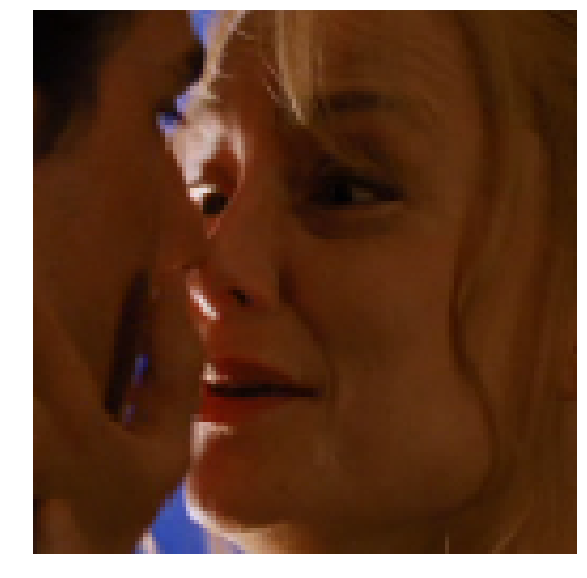

(128, 128, 3)


In [23]:
# pathnameimage = '../out/image960x640.jpg'
pathnameimage = '../out/ferproblem.png'
image = cv2.imread(pathnameimage)[:,:,(2,1,0)]

# bbox = np.array([380, 161, 602, 383], dtype=np.int32)
# imface = roi(image, bbox)

imface = image
imageshow(imface)
print(imface.shape)

ntc.conv1(latt_pool)
torch.Size([1, 64, 32, 32])


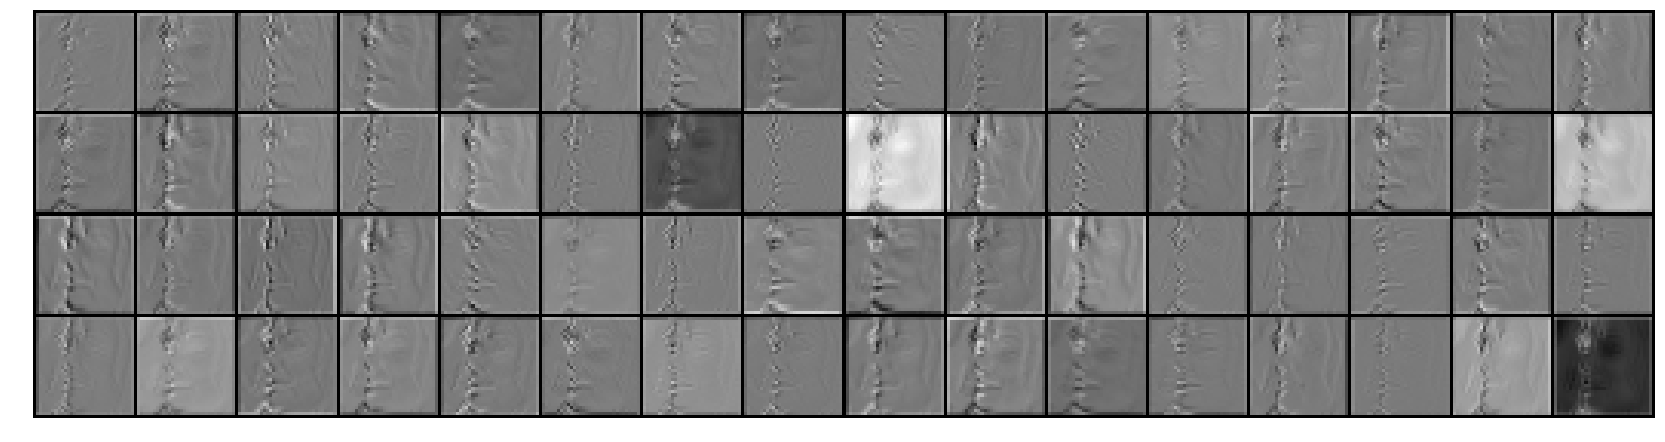

ntc.layer1(out1)
torch.Size([1, 64, 32, 32])


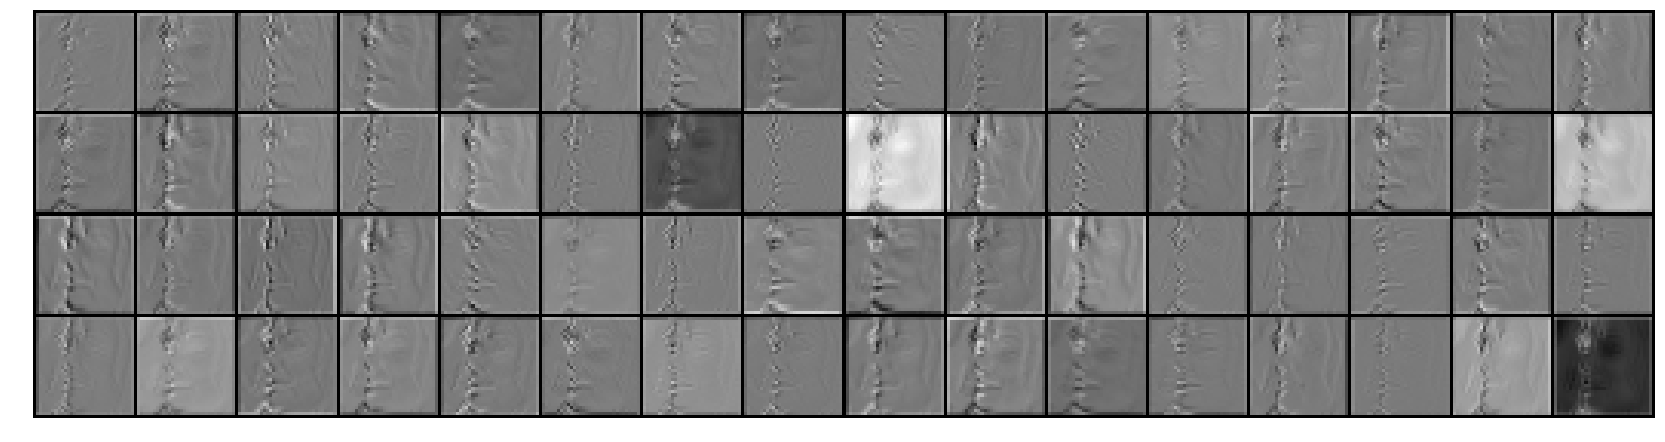

In [31]:
def mean_normalization(image, mean, std):
    tensor = image.float()/255.0
    result_tensor = []
    for t, m, s in zip(tensor, mean, std):  
        result_tensor.append(t.sub_(m).div_(s))            
    return torch.stack(result_tensor, 0)


ntc = network.net

imsize=32
x = imface
x = x.mean(axis=2)        
x = np.stack( (x,x,x), axis=2 )
x = cv2.resize( x, (imsize,imsize) )
x = torch.from_numpy(x).permute( (2,0,1) ).unsqueeze(0).float().cuda()

# x = x/255.0
x = mean_normalization(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

ntc.eval()
out1 = ntc.conv1(x)
out2 = ntc.layer1(out1)
out3 = ntc.layer2(out2)
out4 = ntc.layer3(out3)
out5 = ntc.layer4(out4)

print('ntc.conv1(latt_pool)')
print(out1.shape)
vistensor( out1.cpu().detach(), nrow=16 , allfeature=True, brgb=False, scol=3, srow=1.5 )

print('ntc.layer1(out1)')
print(out2.shape)
vistensor( out1.cpu().detach(), nrow=16 , allfeature=True, brgb=False, scol=3, srow=1.5 )



ntc.layer1(out2)
torch.Size([1, 128, 16, 16])


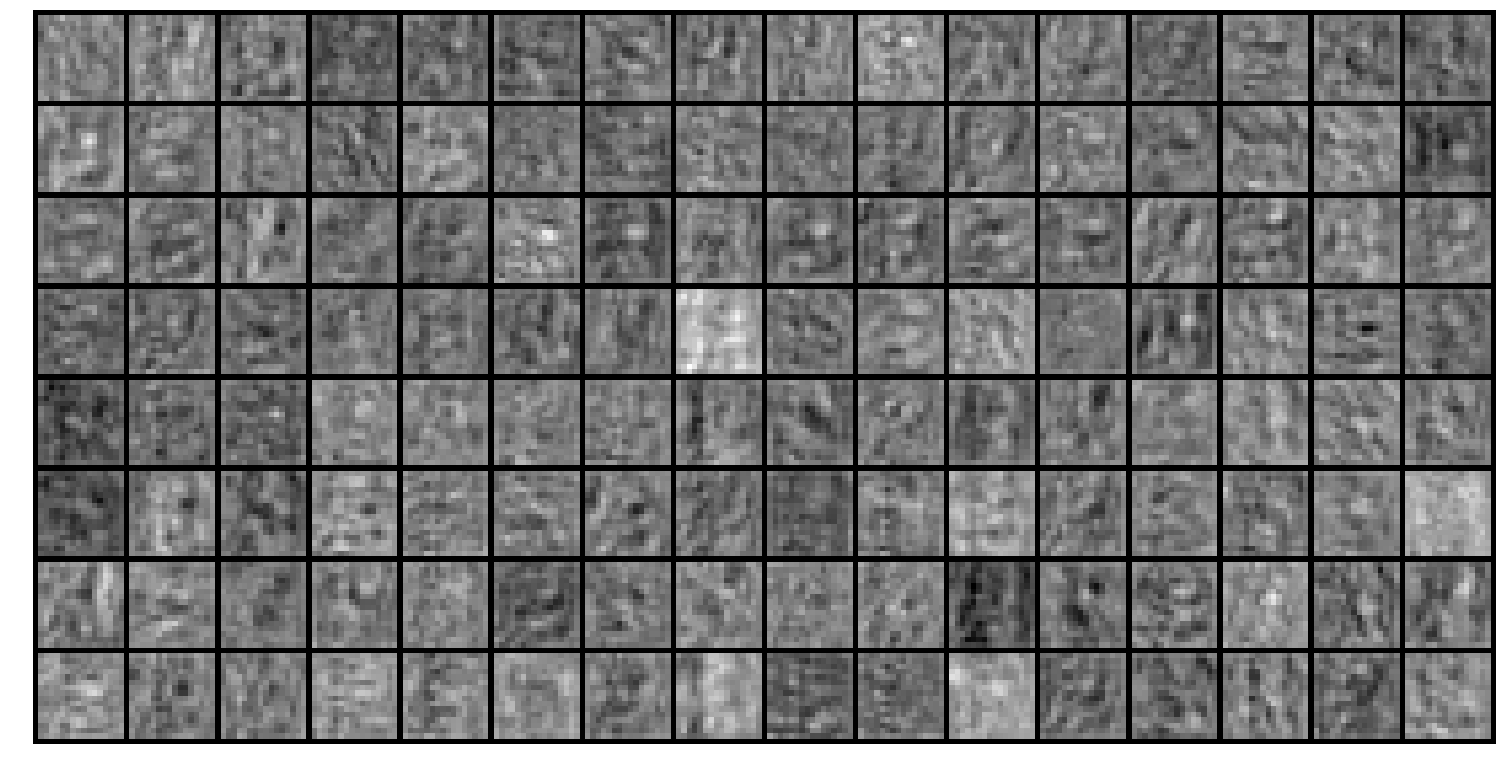

In [32]:
print('ntc.layer1(out2)')
print(out3.shape)
vistensor( out3.cpu().detach(), nrow=16 , allfeature=True, brgb=False, scol=3, srow=1.5 )

ntc.layer1(out3)
torch.Size([1, 256, 8, 8])


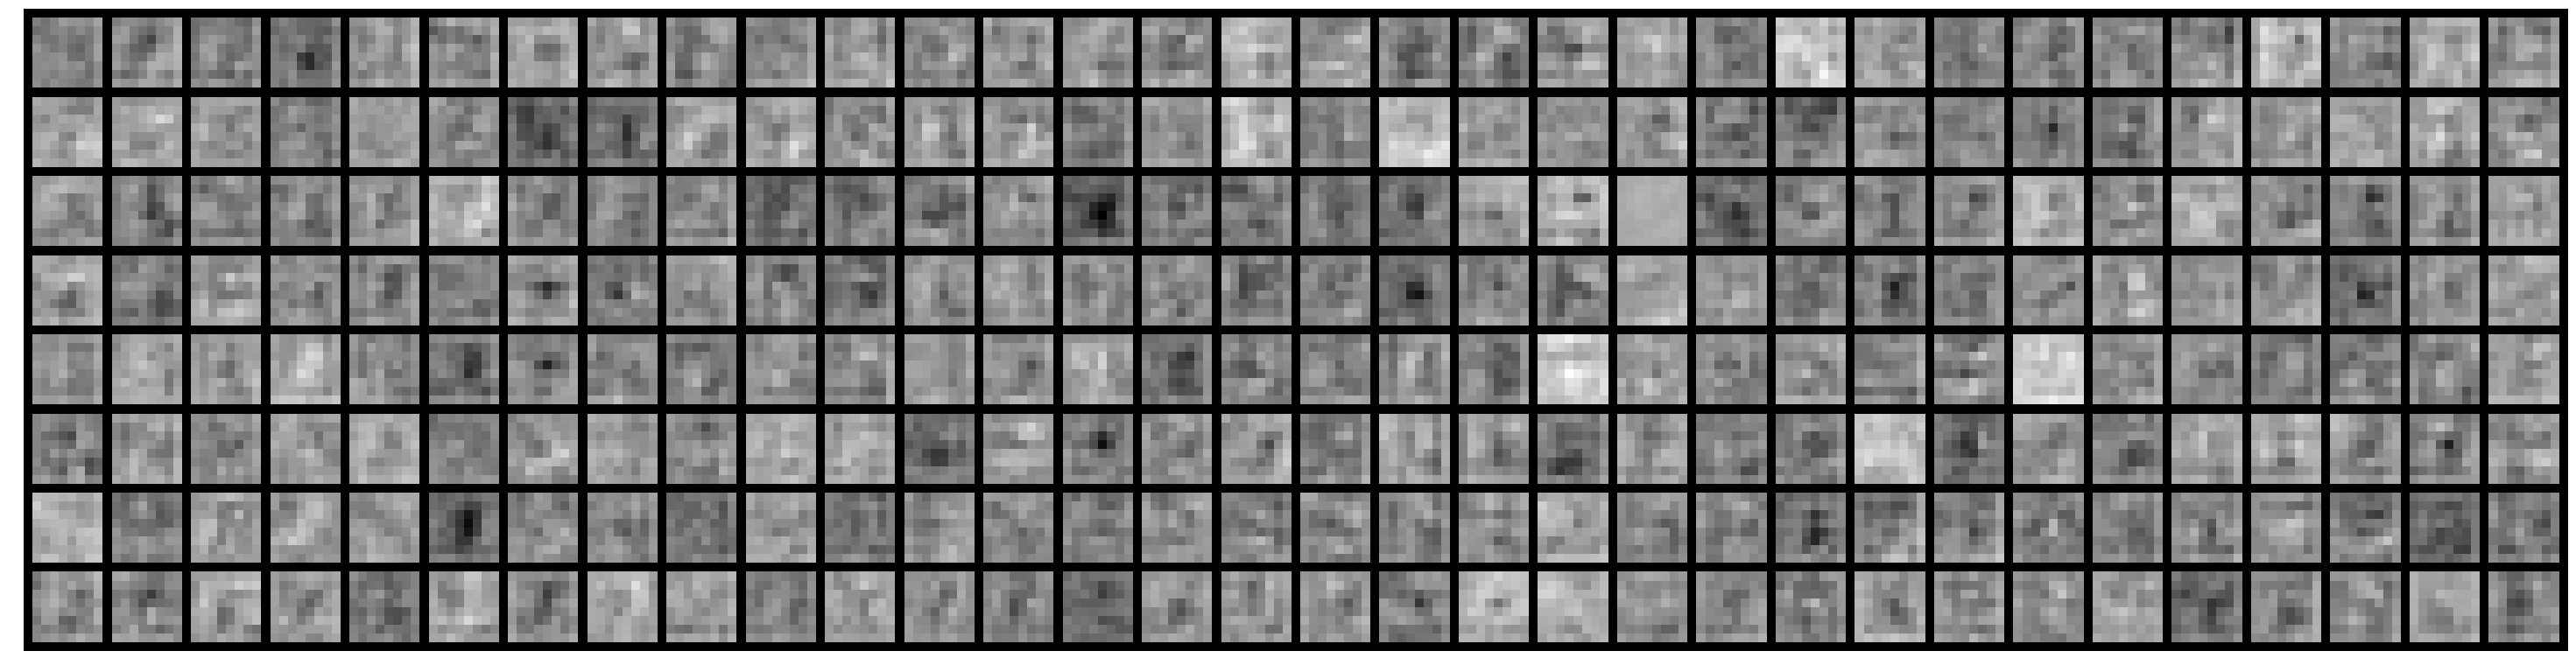

In [33]:
print('ntc.layer1(out3)')
print(out4.shape)
vistensor( out4.cpu().detach(), nrow=32 , allfeature=True, brgb=False, scol=2, srow=1.5 )

ntc.layer1(out4)
torch.Size([1, 512, 4, 4])


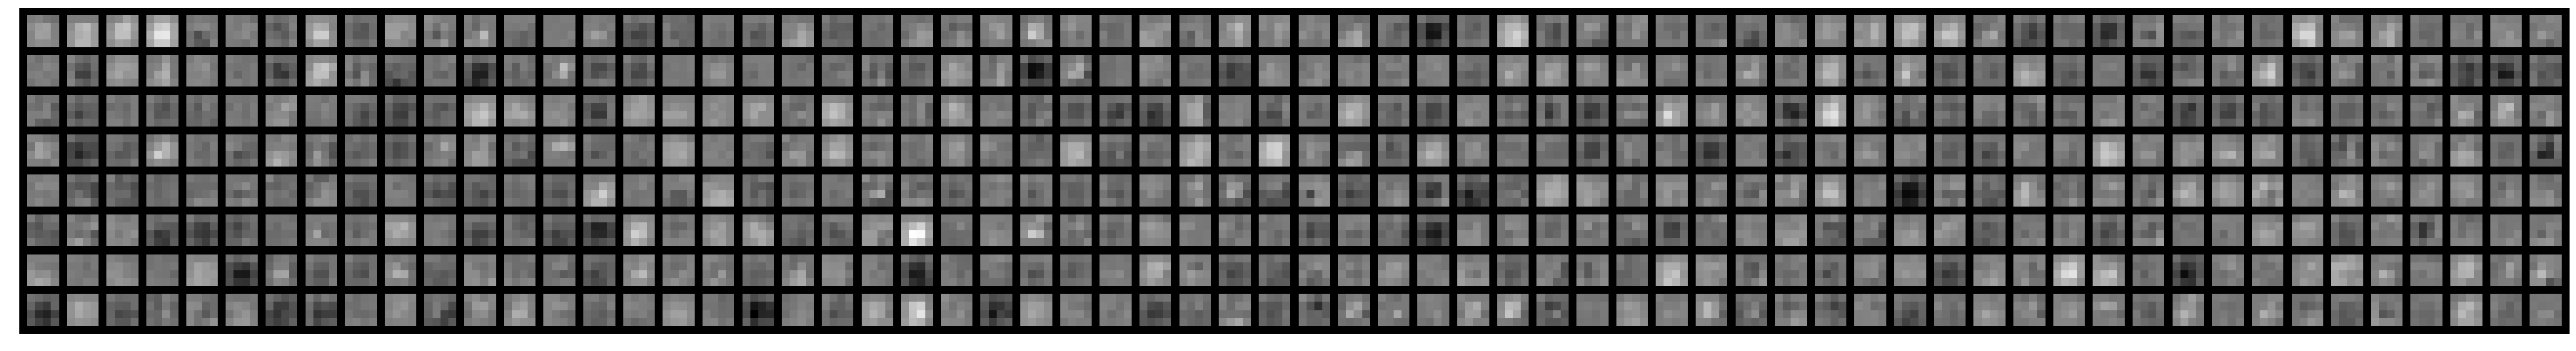

In [34]:
print('ntc.layer1(out4)')
print(out5.shape)
vistensor( out5.cpu().detach(), nrow=64 , allfeature=True, brgb=False, scol=1, srow=1 )

In [35]:
import torch.nn.functional as TF
import operator

emotion_name = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']

ntc = network.net

imsize=32
x = imface
x = x.mean(axis=2)        
x = np.stack( (x,x,x), axis=2 )
x = cv2.resize( x, (imsize,imsize) )
x = torch.from_numpy(x).permute( (2,0,1) ).unsqueeze(0).float().cuda()
# x = x/255.0
x = mean_normalization(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

yhat = ntc(x)
print(yhat)

 
labelhat = TF.softmax( yhat, dim=1 )[0,:]
score = dict(zip(emotion_name, labelhat ))   
curremot = max(score.items(), key=operator.itemgetter(1)) 

print(labelhat)
print(curremot)

print('face: ')
print('----------------------------')
for e,v in score.items():
    print(e, '{:.4f}'.format(v*100) )


tensor([[ 0.8298, -0.1605,  0.7665,  2.0047, -0.1070, -0.4725,  0.5100, -2.9196]],
       device='cuda:1', grad_fn=<AddmmBackward>)
tensor([0.1436, 0.0534, 0.1348, 0.4651, 0.0563, 0.0391, 0.1043, 0.0034],
       device='cuda:1', grad_fn=<SliceBackward>)
('sadness', tensor(0.4651, device='cuda:1', grad_fn=<SelectBackward>))
face: 
----------------------------
neutral 14.3647
happiness 5.3360
surprise 13.4830
sadness 46.5100
anger 5.6294
disgust 3.9060
fear 10.4329
contempt 0.3380
